In [1]:
# -------------------------------------------------------------------------------------
# Third party imports
# -------------------------------------------------------------------------------------
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import os, sys
import glob 

import astropy
from astropy.io import fits
from astropy.time import Time
from astropy.units import allclose as quantity_allclose
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates.builtin_frames import FK5, ICRS, GCRS, GeocentricMeanEcliptic, BarycentricMeanEcliptic, HeliocentricMeanEcliptic, GeocentricTrueEcliptic, BarycentricTrueEcliptic, HeliocentricTrueEcliptic, HeliocentricEclipticIAU76
from astropy.constants import R_sun, R_earth
from astropy.nddata import CCDData

from matplotlib.colors import LogNorm

from ccdproc import Combiner
from ccdproc import wcs_project

import inspect
import importlib
import warnings
warnings.filterwarnings('ignore')

# -------------------------------------------------------------------------------------
# Local imports
# -------------------------------------------------------------------------------------
sys.path.append(os.path.join(os.path.split(os.getcwd())[0], 'shifty'))
import downloader 
import refcat
import imagehandler
import known
import transformer

importlib.reload(downloader)
importlib.reload(refcat)
importlib.reload(imagehandler)
importlib.reload(known)
importlib.reload(transformer)

# Plot setup
matplotlib.rc('font', size=22, family='normal', weight='bold')
plt.rcParams['figure.figsize'] = [10, 4]

In [2]:
#Define a bunch of filenames:
filename = '../dev_data/2015RS281_HSC20160826_112.fits'
filenames=[filename.replace('112', str(i)) for i in np.arange(112, 124)]
#Extract the times of the images
D=imagehandler.DataHandler(filenames)
times = np.array([dh['SHIFTY_MJD_MID'] + 2400000.5 for dh in D.image_data.header])

In [3]:
from astroquery.jplhorizons import Horizons
horizons_query = Horizons(id='2015 RS281', location='568', epochs=times, id_type='smallbody')
horizons_radec = horizons_query.ephemerides(extra_precision=True)
RA_shift = (horizons_radec['RA'] - horizons_radec['RA'][0]) * 3600
Dec_shift = (horizons_radec['DEC'] - horizons_radec['DEC'][0]) * 3600
expected_asec = np.array([RA_shift, Dec_shift]).T
expected_pix = expected_asec / 0.170
print(expected_asec)

[[  0.          0.       ]
 [ -0.7881516  -0.4596084]
 [ -2.0175156  -1.1749212]
 [ -3.216078   -1.8707652]
 [ -4.430034   -2.5743708]
 [ -5.6564532  -3.2844024]
 [ -6.8903856  -3.998412 ]
 [ -8.1534384  -4.7293272]
 [ -9.4365144  -5.4723636]
 [-10.6933104  -6.2011476]
 [-11.9185848  -6.9129792]
 [-13.1777316  -7.6462344]]


In [4]:
importlib.reload(transformer)
T=transformer.Transformer(times=times, time0=times[0],
                          radec0=np.array([(0*3600+41*60+35.095)/3600*15, 6.654141666666667]))
#T=transformer.Transformer(times=times, time0=times[0]-1.1793,
#                          radec0=np.array([9.149641666666666, 7.302588888888889]))
thetas = T(obs_code='568',
           abg=np.array([0.00001486, -0.00001127, 0.02444513, # alpha, beta, gamma
                         0.02121046, -0.01700158, 0.00597633])) # a-dot, b-dot, g-dot
thetas_offset = thetas - thetas[0]  # subtract off common base
thetas_asec = np.degrees(thetas_offset) * 3600  # radians to arcsec
thetas_pix = thetas_asec / 0.170  # arcsec to pixel (accurate to <1%)
print(thetas)
print(thetas_asec, np.degrees(thetas)*3600)

[[ 1.48600000e-05 -1.12700000e-05]
 [ 1.08530493e-05 -1.39140792e-05]
 [ 4.60393923e-06 -1.80287591e-05]
 [-1.48760350e-06 -2.20308830e-05]
 [-7.65654789e-06 -2.60770430e-05]
 [-1.38881264e-05 -3.01595129e-05]
 [-2.01573785e-05 -3.42641358e-05]
 [-2.65742358e-05 -3.84652296e-05]
 [-3.30926754e-05 -4.27352129e-05]
 [-3.94776673e-05 -4.69225568e-05]
 [-4.57027904e-05 -5.10118100e-05]
 [-5.21004535e-05 -5.52234478e-05]]
[[  0.           0.        ]
 [ -0.8264929   -0.54538048]
 [ -2.11546439  -1.39409413]
 [ -3.37193527  -2.21959144]
 [ -4.64437139  -3.05417185]
 [ -5.92972672  -3.89624172]
 [ -7.22285278  -4.74288097]
 [ -8.54642463  -5.60941876]
 [ -9.89094929  -6.49016604]
 [-11.20794842  -7.35386773]
 [-12.49197223  -8.19733673]
 [-13.81158498  -9.06604939]] [[  3.06509502  -2.32460437]
 [  2.23860212  -2.86998485]
 [  0.94963063  -3.7186985 ]
 [ -0.30684025  -4.54419581]
 [ -1.57927637  -5.37877621]
 [ -2.8646317   -6.22084609]
 [ -4.15775776  -7.06748534]
 [ -5.48132961  -7.93402313

In [5]:
print(thetas_asec[0])
print(np.degrees(np.array([0.00001486, -0.00001127]))*3600)
print(np.degrees(np.array([0.00001405, -0.00001186]))*3600)

[0. 0.]
[ 3.06509502 -2.32460437]
[ 2.89802053 -2.4463006 ]


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


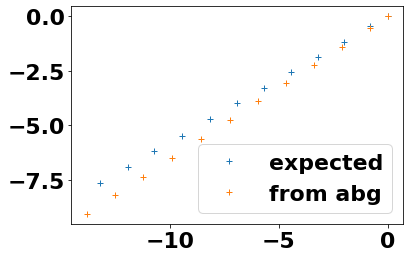

In [6]:
plt.plot(*expected_asec.T, '+', label='expected')
plt.plot(*thetas_asec.T, '+', label='from abg')
plt.gca().set_aspect('equal')
plt.legend()

In [7]:
np.degrees(thetas)*3600

array([[  3.06509502,  -2.32460437],
       [  2.23860212,  -2.86998485],
       [  0.94963063,  -3.7186985 ],
       [ -0.30684025,  -4.54419581],
       [ -1.57927637,  -5.37877621],
       [ -2.8646317 ,  -6.22084609],
       [ -4.15775776,  -7.06748534],
       [ -5.48132961,  -7.93402313],
       [ -6.82585427,  -8.8147704 ],
       [ -8.1428534 ,  -9.67847209],
       [ -9.42687721, -10.5219411 ],
       [-10.74648996, -11.39065375]])

Combining images using mean stacking
123.77598


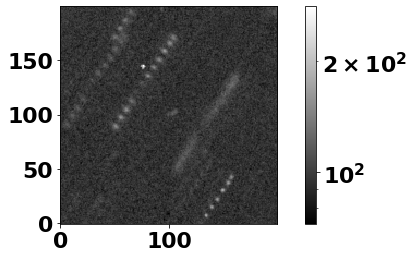

In [8]:
importlib.reload(imagehandler)
D=imagehandler.DataHandler(filenames)
D.integer_shift(thetas_pix, padmean=True)
D.stack(shifted=True)
plt.imshow((D.stacked_data.data-np.nanmin(D.stacked_data.data))[520:720,405:605], origin='lower', cmap='gray',norm=LogNorm())
cbar = plt.colorbar()
print(np.max((D.stacked_data.data-np.nanmin(D.stacked_data.data))[610:630,495:515]))

Combining images using mean stacking
154.04852


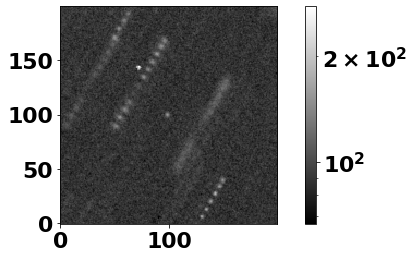

In [9]:
importlib.reload(imagehandler)
D=imagehandler.DataHandler(filenames)
D.integer_shift(expected_pix, padmean=True)
D.stack(shifted=True)
plt.imshow((D.stacked_data.data-np.nanmin(D.stacked_data.data))[520:720,405:605], origin='lower', cmap='gray',norm=LogNorm())
cbar = plt.colorbar()
print(np.max((D.stacked_data.data-np.nanmin(D.stacked_data.data))[610:630,495:515]))

### All the same again, for different object

In [10]:
#pick and object:
obj = '2015 RS281'
if obj == '2015 RK280':
    obj_id = '2015 RK280'
    center = [381, 818]
    abg = np.array([])
    radec0 = np.array([])
    time0 = 2457627.864931231
if obj == '2015 RS281':
    obj_id = '2015 RS281'
    center = [620, 505]
    abg = np.array([0.00001486, -0.00001127, 0.02444513,  # alpha, beta, gamma
                    0.02121046, -0.01700158, 0.00597633]) # a-dot, b-dot, g-dot
    radec0 = np.array([10.396229166666668, 6.654141666666667])
    time0 = 2457627.864931231
if obj == '2015 RS281 - 2':
    obj_id = '2015 RS281'
    center = [620, 505]
    abg=np.array([0.00001405, -0.00001186, 0.02403883,  # alpha, beta, gamma
                  0.02094753, -0.01681588, 0.00589037]) # a-dot, b-dot, g-dot
    radec0 = np.array([9.149641666666666, 7.302588888888889])
    time0 = 2457197.1057
    

In [11]:
from astroquery.jplhorizons import Horizons
horizons_query = Horizons(id='2015 RK280', location='568', epochs=times, id_type='smallbody')
horizons_radec = horizons_query.ephemerides(extra_precision=False)
RA_shift = (horizons_radec['RA'] - horizons_radec['RA'][0]) * 3600
Dec_shift = (horizons_radec['DEC'] - horizons_radec['DEC'][0]) * 3600
expected_asec = np.array([RA_shift, Dec_shift]).T
expected_pix = expected_asec / 0.170
print(expected_asec)

[[  0.      0.   ]
 [ -0.792  -0.216]
 [ -1.98   -0.54 ]
 [ -3.168  -0.9  ]
 [ -4.356  -1.224]
 [ -5.58   -1.584]
 [ -6.804  -1.944]
 [ -8.028  -2.268]
 [ -9.288  -2.628]
 [-10.548  -2.988]
 [-11.736  -3.348]
 [-12.996  -3.708]]


In [12]:
horizons_radec['RA'][0], horizons_radec['DEC'][0]

(10.87825, 6.60627)

In [13]:
importlib.reload(transformer)
T=transformer.Transformer(times=times, time0=times[0],
                          radec0=np.array([(0*3600+41*60+53.322)/3600*15, (5*3600+52*60+16.62)/3600]))
thetas = T(obs_code='568',
           abg=np.array([0.00001340, 0.00000538, 0.02131436, # alpha, beta, gamma
                         0.01748698, 0.00770967, 0.00133697])) # a-dot, b-dot, g-dot
thetas_offset = thetas - thetas[0]  # subtract off common base
thetas_asec = np.degrees(thetas_offset) * 3600  # radians to arcsec
thetas_pix = thetas_asec / 0.170  # arcsec to pixel (accurate to <1%)
print(thetas_asec, np.degrees(thetas)*3600)

[[  0.           0.        ]
 [ -0.72870038  -0.28471828]
 [ -1.865126    -0.72792475]
 [ -2.97286493  -1.15917449]
 [ -4.09465263  -1.59534957]
 [ -5.22780933  -2.03563277]
 [ -6.36780258  -2.478509  ]
 [ -7.53462902  -2.93201045]
 [ -8.71992726  -3.39317388]
 [ -9.88096752  -3.84563056]
 [-11.01295164  -4.28769138]
 [-12.17633183  -4.74318334]] [[ 2.7639484   1.10970466]
 [ 2.03524803  0.82498638]
 [ 0.89882241  0.38177991]
 [-0.20891652 -0.04946984]
 [-1.33070423 -0.48564492]
 [-2.46386092 -0.92592812]
 [-3.60385417 -1.36880434]
 [-4.77068062 -1.82230579]
 [-5.95597885 -2.28346922]
 [-7.11701911 -2.7359259 ]
 [-8.24900323 -3.17798672]
 [-9.41238343 -3.63347868]]


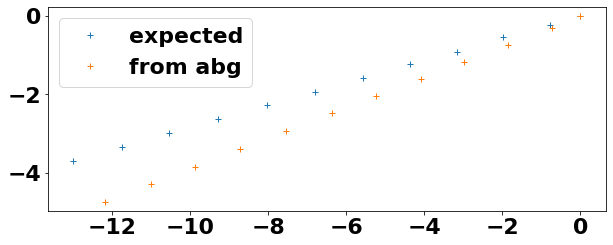

In [14]:
thetas_asec, expected_asec
plt.plot(*expected_asec.T, '+', label='expected')
plt.plot(*thetas_asec.T, '+', label='from abg')
plt.gca().set_aspect('equal')
plt.legend()